In [ ]:
import cv2
import os
import shutil
import numpy as np

In [ ]:
dataset_path = '/content/drive/MyDrive/ML/HITS/Module2/mask_dataset_old_version/'
train_images_path = dataset_path+'train/images/'
train_annotation_path = dataset_path+'train/annotation/'

test_images_path = dataset_path+'test/images/'
test_annotation_path = dataset_path+'test/annotation/'

In [ ]:
def load_images_from_folder(folder):
    images = []
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (512, 512))
        if img is not None:
            images.append(img)
    return files, images

In [ ]:
img_names, img_list = load_images_from_folder(train_images_path)
msk_names, msk_list = load_images_from_folder(train_annotation_path)


x = np.asarray(img_list, dtype=np.float32)/255
y = np.asarray(msk_list, dtype=np.float32)/255
y[y>0] = 1
y = y.sum(axis=3).reshape(47, y.shape[1], y.shape[2], 1)

Text(0.5, 1.0, 'Сегментация')

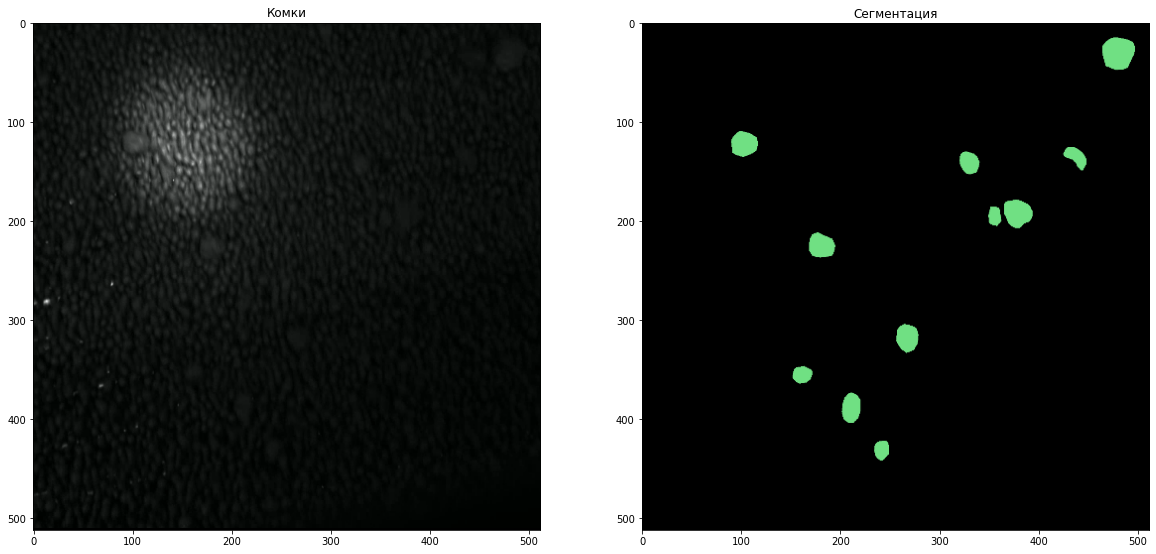

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 2, 1)
index = 0
imgplot = plt.imshow(img_list[index])
a.set_title('Комки')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(msk_list[index])
a.set_title('Сегментация')

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (42, 512, 512, 3)
y_train:  (42, 512, 512, 1)
x_val:  (5, 512, 512, 3)
y_val:  (5, 512, 512, 1)


In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
pip install keras-unet

In [ ]:
sample_batch = next(train_gen)
xx, yy = sample_batch

In [ ]:
xx.shape

(2, 512, 512, 3)

In [ ]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4
)

#model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint

model_filename = '/content/unet_1024_cFOS_old.hdf5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [ ]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=200,
    epochs=50,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: -0.7982 - iou: 0.2900 - iou_thresholded: 0.7773
Epoch 1: val_loss improved from inf to 47.48003, saving model to /content/unet_1024_cFOS_old.hdf5
200/200 [==============================] - 123s 522ms/step - loss: -0.7982 - iou: 0.2900 - iou_thresholded: 0.7773 - val_loss: 47.4800 - val_iou: 0.0537 - val_iou_thresholded: 0.0537
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: -3.9404 - iou: 0.7982 - iou_thresholded: 0.9965
Epoch 2: val_loss improved from 47.48003 to 4.31102, saving model to /content/unet_1024_cFOS_old.hdf5
200/200 [==============================] - 100s 499ms/step - loss: -3.9404 - iou: 0.7982 - iou_thresholded: 0.9965 - val_loss: 4.3110 - val_iou: 0.3970 - val_iou_thresholded: 0.3970
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: -7.6380 - iou: 0.9285 - iou_thresholded: 1.1351
Epoch 3: val_loss improved from 4.31102 to -14.08234, saving model to /content/un

In [ ]:
img_names, img_list = load_images_from_folder(test_images_path)
msk_names, msk_list = load_images_from_folder(test_annotation_path)


x_test = np.asarray(img_list, dtype=np.float32)/255
y_test = np.asarray(msk_list, dtype=np.float32)/255
y_test[y_test>0] = 1
y_test = y_test.sum(axis=3).reshape( y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

In [ ]:
model.load_weights(model_filename)
y_pred = model.predict(x_test)

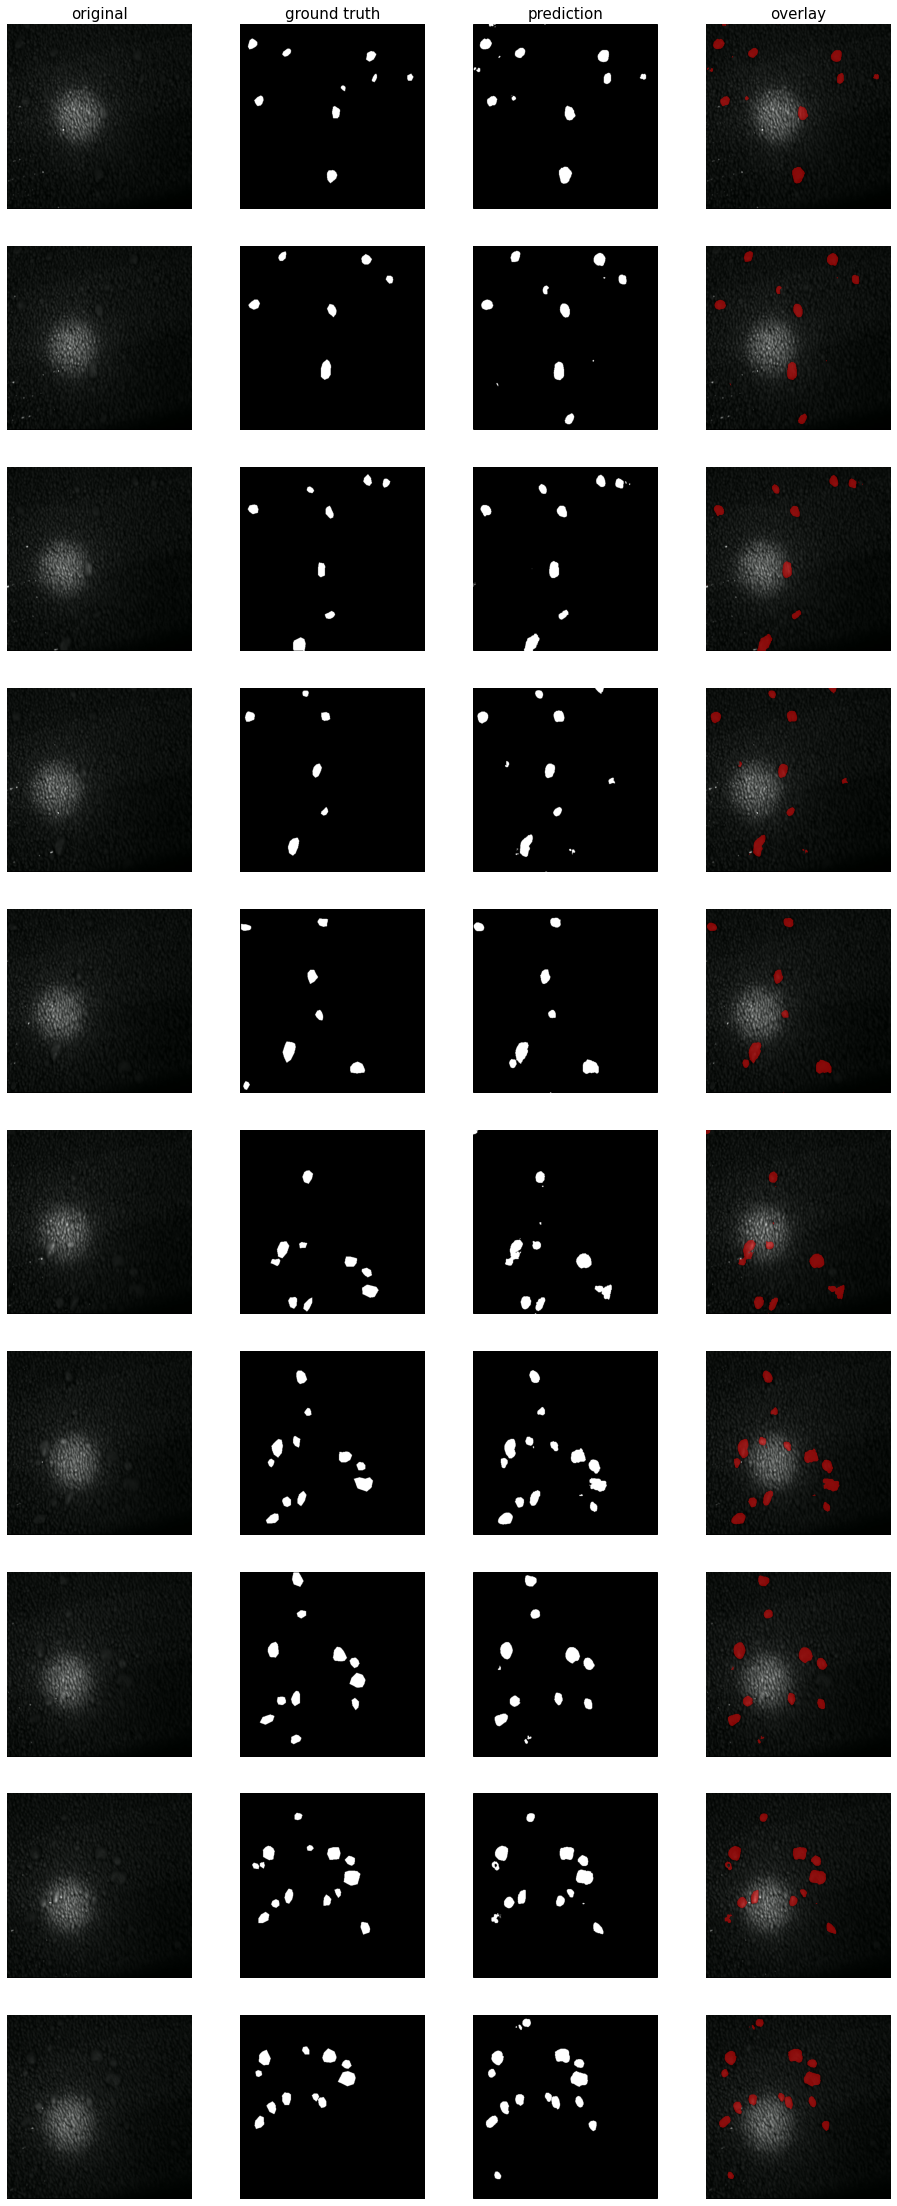

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

# Новый раздел